In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
import datetime
import category_encoders as ce
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [3]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

In [6]:
res = []
for method in ['saa', 'timeseries', 'one-hot encoding', 'target encoding', 'week_of_month_one-hot', 'week_of_month_target']:
#for method in ['week_of_month_one-hot', 'week_of_month_target']:
#for method in ['target encoding_']:
    for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
        if method == 'timeseries':
            df = load_yaz(encode_date_features=False, include_prod=[target], include_date=True).frame
            df['DEMAND_DATE'] = pd.to_datetime(df['DEMAND_DATE'])
            df['DEMAND_DATE'] = (df['DEMAND_DATE'] - datetime.datetime(1970,1,1)).astype('timedelta64[D]').values
            df = df[['DEMAND_DATE',target]]

        elif method == 'one-hot encoding':
            df = load_yaz(encode_date_features=True, include_prod=[target], include_date=True).frame
            df = df.sort_values('DEMAND_DATE')
            df.insert(loc=0, column='NextDayHOLIDAY', value=df['ISHOLIDAY'].shift(-1).fillna(0))
            df = df.drop(columns = 'DEMAND_DATE')

        elif method == 'target encoding':
            df = load_yaz(encode_date_features=False, include_prod=[target], include_date=True).frame
            df = df.sort_values('DEMAND_DATE')
            df.insert(loc=0, column='NextDayHOLIDAY', value=df['ISHOLIDAY'].shift(-1).fillna(0))
            df = df.drop(columns = 'DEMAND_DATE')

        elif method == 'saa':
            df = load_yaz(encode_date_features=False, include_prod=[target], include_date=False).frame 
        
        elif method == 'week_of_month_one-hot':
            df = load_yaz(encode_date_features=True, include_prod=[target], include_date=True).frame
            df.insert(loc=0, column='week_of_month', value = df.apply(lambda row: week_of_month(row.DEMAND_DATE), axis=1))
            df = df.sort_values('DEMAND_DATE')
            df.insert(loc=0, column='NextDayHOLIDAY', value=df['ISHOLIDAY'].shift(-1).fillna(0))
            df = df.drop(columns = 'DEMAND_DATE')
            
        elif method == 'week_of_month_target':
            df = load_yaz(encode_date_features=False, include_prod=[target], include_date=True).frame
            df.insert(loc=0, column='week_of_month', value = df.apply(lambda row: week_of_month(row.DEMAND_DATE), axis=1))
            df = df.sort_values('DEMAND_DATE')
            df.insert(loc=0, column='NextDayHOLIDAY', value=df['ISHOLIDAY'].shift(-1).fillna(0))
            df = df.drop(columns = 'DEMAND_DATE')

        # make train/val/test
        n_train = 600
        train_x_df, train_y_df = df.iloc[:n_train, :-1], df.iloc[:n_train, -1]
        test_x_df, test_y_df = df.iloc[n_train:, :-1], df.iloc[n_train:, -1]
        
        train_y = train_y_df.values
        test_y = test_y_df.values

        # target encoding
        if method == 'target encoding':
            for cat in ['WEEKDAY', 'MONTH', 'YEAR']:
                encoder = ce.TargetEncoder()
                train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)
                test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))
                
        elif method == 'week_of_month_target':
            for cat in ['WEEKDAY', 'MONTH', 'YEAR', 'ISHOLIDAY', 'WEEKEND', 'week_of_month']:
                encoder = ce.TargetEncoder()
                train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)
                test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))
        elif method == 'week_of_month_one-hot':
            for cat in ['week_of_month']:
                encoder = ce.OneHotEncoder()
                train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)], axis=1).drop(columns = cat)
                test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)
    
        if method != 'saa':
            scaler = MinMaxScaler()
            scaler.fit(train_x_df)

            train_x = scaler.transform(train_x_df)
            test_x = scaler.transform(test_x_df)

            # Kernel with parameters given in GPML book
            k1 = 1**2 * RBF(length_scale=0.261)  # long term smooth rising trend
            k2 = 2.4**2 * RBF(length_scale=90.0) \
                * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
            k3 = 0.66**2 \
                * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
            k4 = 0.18**2 * RBF(length_scale=0.134) \
                + WhiteKernel(noise_level=1.09**2)  # noise terms

            if method == 'timeseries':
                kernel_gpml = k1 + k2 + k3 + k4

            else:
                kernel_gpml = k1 + k4

            gp = GaussianProcessRegressor(kernel=kernel_gpml, normalize_y=True, n_restarts_optimizer=10)#, alpha=1)
            gp.fit(train_x, train_y)

            print("\nLearned kernel: %s" % gp.kernel_)
            print("Log-marginal-likelihood: %.3f"
                  % gp.log_marginal_likelihood(gp.kernel_.theta))

            nv_means, y_std = gp.predict(test_x,  return_std=True)
            nv_sigma = y_std

        for c in range(5,100, 5):
            cu = c/100
            co = 1-cu

            if method == 'saa':
                nv_quantile = np.quantile(train_y, q=cu/(cu+co))
                cost= np.mean([nv_cost(nv_quantile, y, cu, co) for y in test_y])
                nv_means, nv_sigma = 0,0
            else:
                nv_solution = nv_means+norm.ppf(cu/(cu+co))*nv_sigma
                cost =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, test_y)])

            ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target})
            res.append(ser_tmp)
        df_res = pd.DataFrame(res)


Learned kernel: 0.99**2 * RBF(length_scale=0.000368) + 0.00316**2 * RBF(length_scale=4.05e+04) * ExpSineSquared(length_scale=3.08e+04, periodicity=0.51) + 0.0291**2 * RationalQuadratic(alpha=1.18e+03, length_scale=1.24e-05) + 0.148**2 * RBF(length_scale=0.273) + WhiteKernel(noise_level=5.52e-05)
Log-marginal-likelihood: -848.113

Learned kernel: 0.00316**2 * RBF(length_scale=16.9) + 0.166**2 * RBF(length_scale=0.133) * ExpSineSquared(length_scale=5.47e+03, periodicity=15.2) + 0.00316**2 * RationalQuadratic(alpha=2.03e+04, length_scale=1.85e+03) + 0.988**2 * RBF(length_scale=4.87e-05) + WhiteKernel(noise_level=1e-05)
Log-marginal-likelihood: -847.850

Learned kernel: 0.207**2 * RBF(length_scale=0.13) + 0.00776**2 * RBF(length_scale=0.356) * ExpSineSquared(length_scale=156, periodicity=0.00191) + 0.00316**2 * RationalQuadratic(alpha=0.000238, length_scale=19.5) + 0.983**2 * RBF(length_scale=0.000648) + WhiteKernel(noise_level=1.2e-05)
Log-marginal-likelihood: -845.162

Learned kernel: 0

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.288**2 * RBF(length_scale=1e-05) + 0.837**2 * RBF(length_scale=1.46) + WhiteKernel(noise_level=0.653)
Log-marginal-likelihood: -781.160


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.619**2 * RBF(length_scale=1.01) + 0.867**2 * RBF(length_scale=0.0456) + WhiteKernel(noise_level=0.0348)
Log-marginal-likelihood: -801.042


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.0325**2 * RBF(length_scale=0.000358) + 1.25**2 * RBF(length_scale=2) + WhiteKernel(noise_level=0.654)
Log-marginal-likelihood: -749.699


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.11**2 * RBF(length_scale=1.19) + 0.113**2 * RBF(length_scale=0.0914) + WhiteKernel(noise_level=0.394)
Log-marginal-likelihood: -628.742


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.4**2 * RBF(length_scale=1.65) + 0.544**2 * RBF(length_scale=0.0775) + WhiteKernel(noise_level=0.213)
Log-marginal-likelihood: -680.118


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.23**2 * RBF(length_scale=1.57) + 0.274**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.392)
Log-marginal-likelihood: -643.296


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.22**2 * RBF(length_scale=1.31) + 0.302**2 * RBF(length_scale=0.458) + WhiteKernel(noise_level=0.427)
Log-marginal-likelihood: -653.724


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.00546**2 * RBF(length_scale=0.839) + 0.768**2 * RBF(length_scale=2.44) + WhiteKernel(noise_level=0.723)
Log-marginal-likelihood: -801.098


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.591**2 * RBF(length_scale=1.62) + 0.0322**2 * RBF(length_scale=0.0557) + WhiteKernel(noise_level=0.729)
Log-marginal-likelihood: -816.291


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.322**2 * RBF(length_scale=0.00104) + 0.919**2 * RBF(length_scale=2.31) + WhiteKernel(noise_level=0.492)
Log-marginal-likelihood: -767.318


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.241**2 * RBF(length_scale=0.00031) + 1.29**2 * RBF(length_scale=2.85) + WhiteKernel(noise_level=0.323)
Log-marginal-likelihood: -659.343


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.658**2 * RBF(length_scale=0.00391) + 1.12**2 * RBF(length_scale=2.49) + WhiteKernel(noise_level=0.0186)
Log-marginal-likelihood: -706.821


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.00316**2 * RBF(length_scale=0.17) + 1.12**2 * RBF(length_scale=2.45) + WhiteKernel(noise_level=0.382)
Log-marginal-likelihood: -668.927


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.2**2 * RBF(length_scale=0.000115) + 0.966**2 * RBF(length_scale=2.06) + WhiteKernel(noise_level=0.361)
Log-marginal-likelihood: -690.773


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 0.778**2 * RBF(length_scale=1.38) + 0.31**2 * RBF(length_scale=0.171) + WhiteKernel(noise_level=0.641)
Log-marginal-likelihood: -780.412


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 0.665**2 * RBF(length_scale=1.06) + 0.878**2 * RBF(length_scale=0.0683) + WhiteKernel(noise_level=1e-05)
Log-marginal-likelihood: -797.356


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.24**2 * RBF(length_scale=1.97) + 0.489**2 * RBF(length_scale=0.0788) + WhiteKernel(noise_level=0.409)
Log-marginal-likelihood: -747.743


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.11**2 * RBF(length_scale=1.17) + 0.628**2 * RBF(length_scale=0.000184) + WhiteKernel(noise_level=1e-05)
Log-marginal-likelihood: -626.112


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.61**2 * RBF(length_scale=2.05) + 0.462**2 * RBF(length_scale=0.116) + WhiteKernel(noise_level=0.295)
Log-marginal-likelihood: -683.010


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.18**2 * RBF(length_scale=1.48) + 0.272**2 * RBF(length_scale=0.295) + WhiteKernel(noise_level=0.386)
Log-marginal-likelihood: -642.372


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.45**2 * RBF(length_scale=1.69) + 0.308**2 * RBF(length_scale=0.514) + WhiteKernel(noise_level=0.422)
Log-marginal-likelihood: -657.805


nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

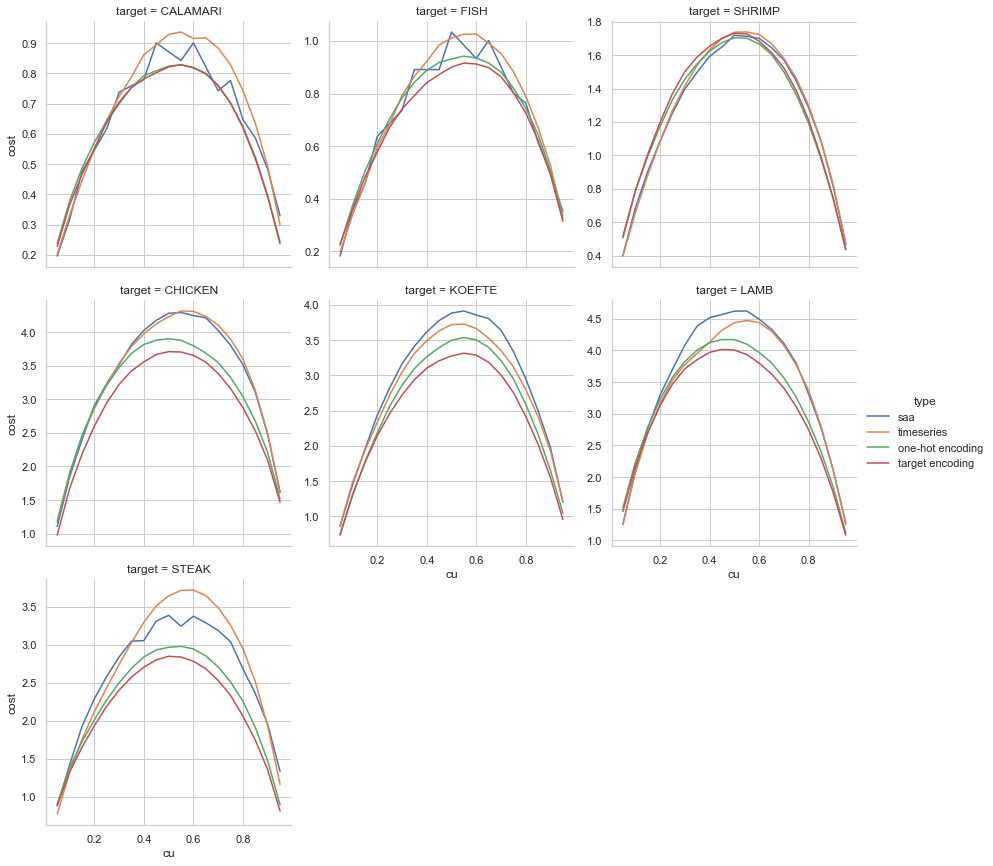

In [9]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
df_plot = df_plot[~(df_plot.type.isin(["week_of_month_target", "week_of_month_one-hot"]))]
#df_plot = df_plot[~(df_plot.type.isin(["timeseries", "one-hot encoding", "week_of_month_target", "week_of_month_one-hot"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},
    col="target", hue="type",kind="line", aspect=1, height=4); 

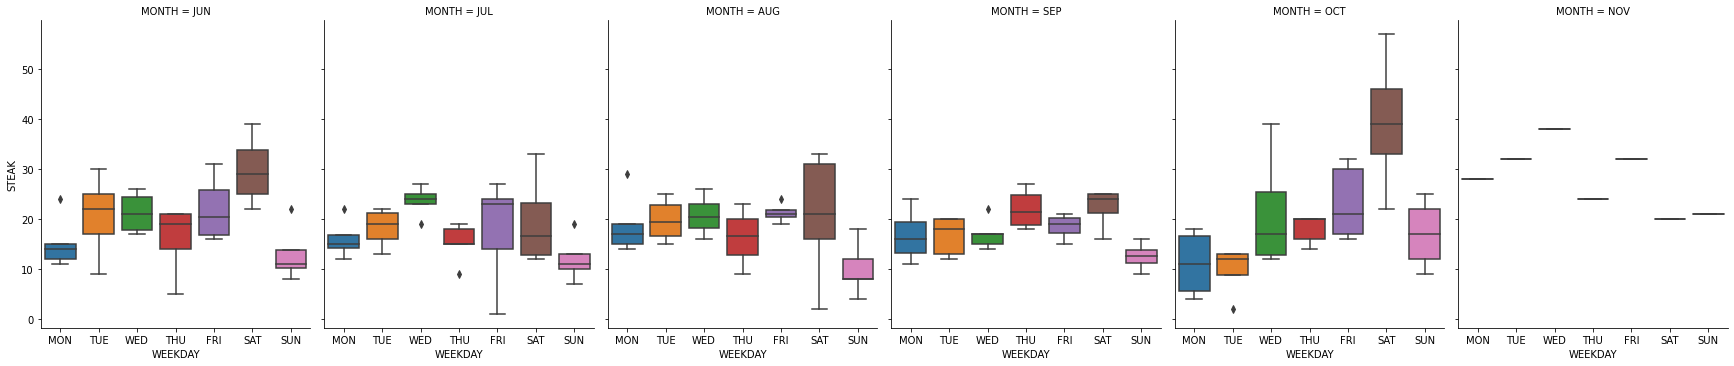

In [8]:
test_df = load_yaz(encode_date_features=False, include_prod=[target]).frame.iloc[n_train:,:].copy()
test_df['mean_pred'] =nv_means
test_df['std'] = nv_sigma


g = sns.catplot(x="WEEKDAY", y="STEAK",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

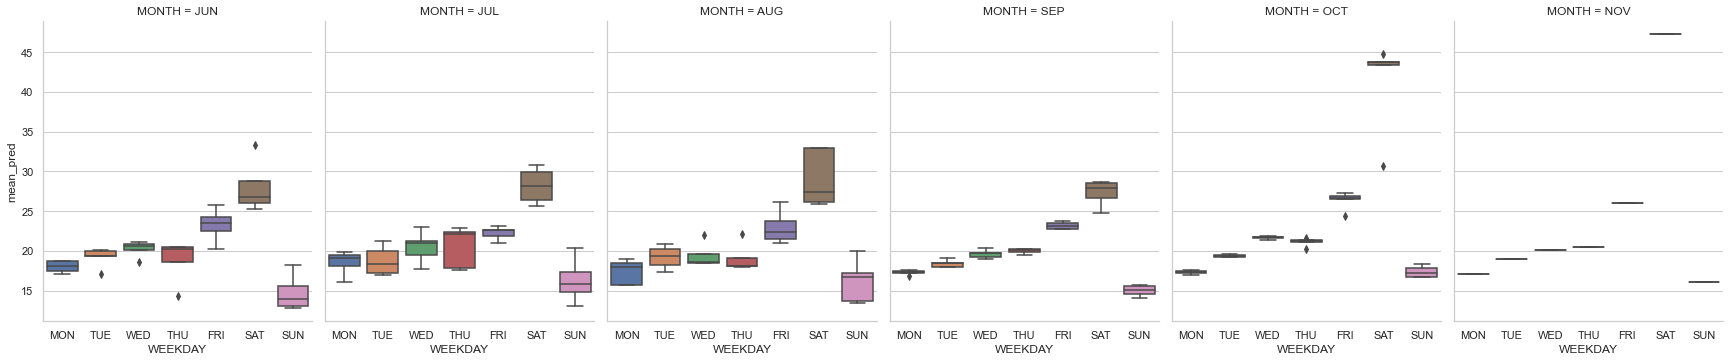

In [87]:
g = sns.catplot(x="WEEKDAY", y="mean_pred",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

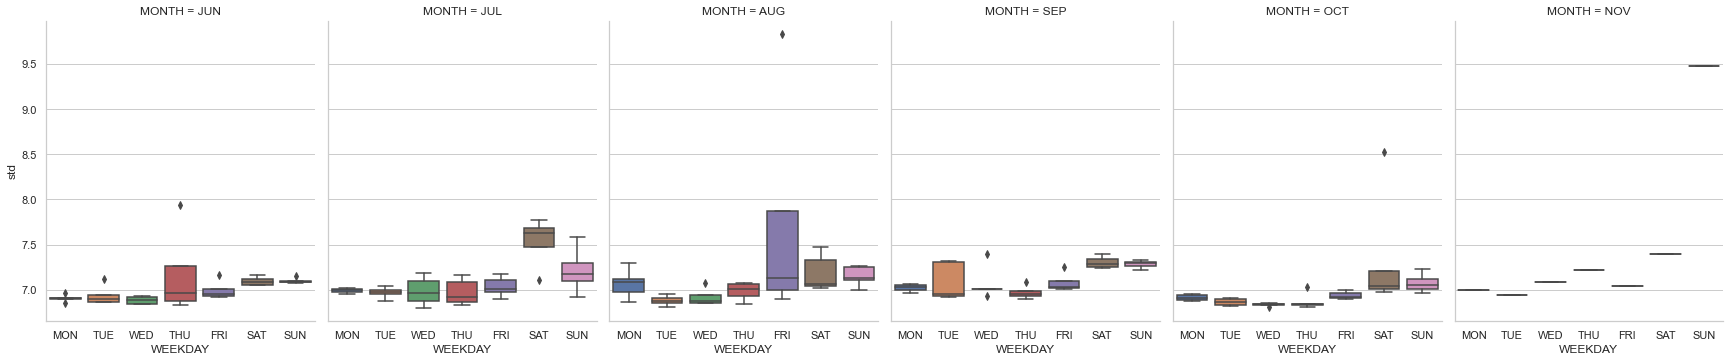

In [88]:
g = sns.catplot(x="WEEKDAY", y="std",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

## Plot Space

In [46]:
f0 = [torch.linspace(0, 1, 200) for i in range(1)]
fx = torch.linspace(1,1, 200) #temp
fn = [torch.linspace(0, 1, 200) for i in range(5)]#[torch.linspace(0.5, 0.5, 200) for i in range(2)]


In [47]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    sample_x = torch.stack([*f0,fx,*fn] , axis=-1).cuda()
    observed_pred = likelihood(model(sample_x))

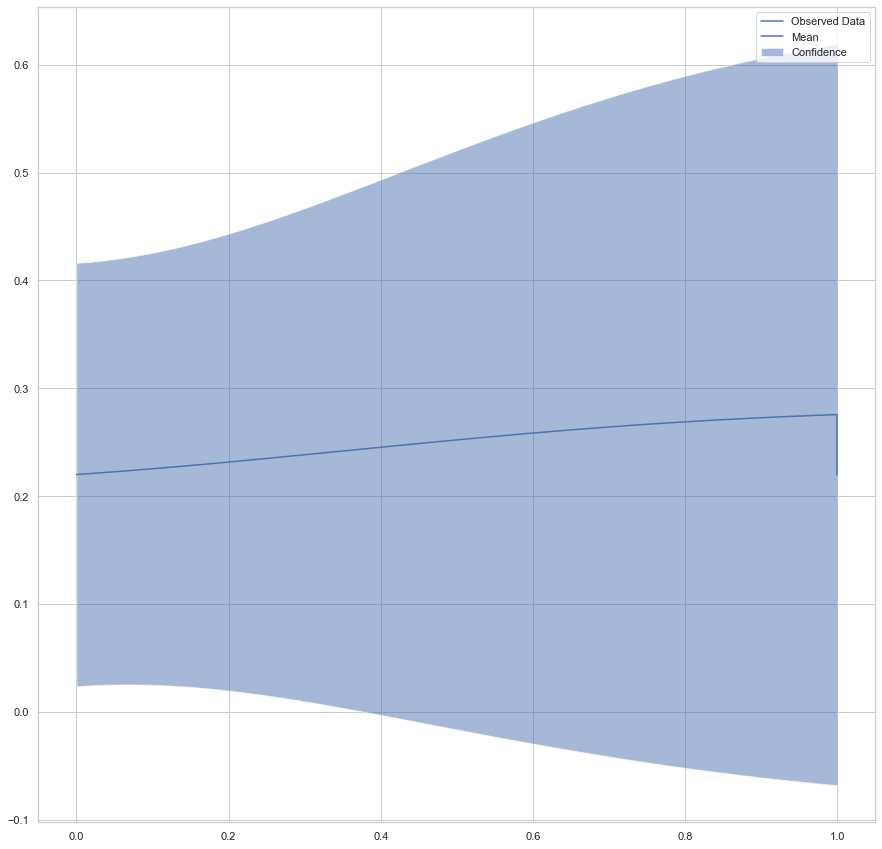

In [48]:
feature_idx=2
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    # Plot predictive means as blue line
    ax.plot(fx.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])